In [53]:
from halotools import empirical_models
import numpy as np
import abcpmc
import matplotlib.pylab as plt
%matplotlib inline

In [54]:
from halotools.empirical_models import Zheng07
model = Zheng07()

In [55]:
model.populate_mock()
print model.param_dict
true_hod = model.param_dict.values()

{'logM0': 11.38, 'sigma_logM': 0.26, 'logMmin': 12.02, 'alpha': 1.06, 'logM1': 13.31}


In [56]:
#Create some data!
data= model.mock.number_density
print data

0.004793088


In [60]:
Npart = 350
threshold ="ExpEps"
Iter = 25
epimax=.01
epimin=.0001
part_prop = 'KNN'
knn=30
    
def dist(x, y):
    return np.abs((x) - (y))
    
def postfn(theta):
    #'logM0': 11.38, 'sigma_logM': 0.26, 'logMmin': 12.02, 'alpha': 1.06, 'logM1': 13.31
    model.param_dict['logM0'] = theta[0]
    model.param_dict['sigma_logM'] = theta[1]
    model.param_dict['logMmin'] = theta[2]
    model.param_dict['alpha'] = theta[3]
    model.param_dict['logM1'] = theta[4]
    model.populate_mock()
    nbar= model.mock.number_density
    #print "nbar",nbar
    return nbar

if threshold == 'ConstEps':
    eps = abcpmc.ConstEps(Iter, epimax)
elif threshold == 'ExpEps':
    eps = abcpmc.ExponentialEps(Iter, epimax,epimin)
else:
    eps = abcpmc.LinearEps(Iter, epimax, epimin)
        
#just add simple prior limits
upper = np.array(model.param_dict.values())+np.array(model.param_dict.values())*0.1 
lower = np.array(model.param_dict.values()) - np.array(model.param_dict.values())*0.1 
print upper, lower
prior = abcpmc.TophatPrior(lower , upper)

sampler = abcpmc.Sampler(N=Npart, Y=data, postfn=postfn, dist=dist)

abcpmc.Sampler.particle_proposal_kwargs = {}
if part_prop == 'KNN':
    abcpmc.Sampler.particle_proposal_kwargs = {'k':knn}
    sampler.particle_proposal_cls = abcpmc.KNNParticleProposal
elif part_prop == 'OLCM':
    sampler.particle_proposal_cls = abcpmc.OLCMParticleProposal
    
pools=[]   
for pool in sampler.sample(prior, eps):
    print("T: {0}, eps: {1:>.4f}, ratio: {2:>.4f}".format(pool.t, pool.eps, pool.ratio))
    for i, (mean, std) in enumerate(zip(np.mean(pool.thetas, axis=0), np.std(pool.thetas, axis=0))):
        print(u"    theta[{0}]: {1:>.4f} \u00B1 {2:>.4f}".format(i, mean,std))
    pools.append(pool)


[ 13.36576741   0.32336989  13.9093982    1.13166819  13.91056714] [ 10.93562788   0.26457537  11.38041671   0.92591034  11.38137311]
T: 0, eps: 0.0100, ratio: 0.6903
    theta[0]: 12.2033 ± 0.6918
    theta[1]: 0.2938 ± 0.0165
    theta[2]: 12.7341 ± 0.6709
    theta[3]: 1.0228 ± 0.0604
    theta[4]: 13.0108 ± 0.5495
T: 1, eps: 0.0083, ratio: 0.8772
    theta[0]: 12.2182 ± 0.7611
    theta[1]: 0.2920 ± 0.0241
    theta[2]: 12.8361 ± 0.6951
    theta[3]: 1.0153 ± 0.0820
    theta[4]: 13.1376 ± 0.5513
T: 2, eps: 0.0068, ratio: 0.8997
    theta[0]: 12.2497 ± 0.7619
    theta[1]: 0.2929 ± 0.0286
    theta[2]: 12.8705 ± 0.6936
    theta[3]: 1.0134 ± 0.0979
    theta[4]: 13.0801 ± 0.5524
T: 3, eps: 0.0056, ratio: 0.9021
    theta[0]: 12.2728 ± 0.7321
    theta[1]: 0.2993 ± 0.0331
    theta[2]: 12.8937 ± 0.6570
    theta[3]: 1.0316 ± 0.1066
    theta[4]: 13.1205 ± 0.5530
T: 4, eps: 0.0046, ratio: 0.8685
    theta[0]: 12.3104 ± 0.7153
    theta[1]: 0.2968 ± 0.0331
    theta[2]: 12.9007 ± 0.62

In [62]:
#{'logM0': 11.38, 'sigma_logM': 0.26, 'logMmin': 12.02, 'alpha': 1.06, 'logM1': 13.31}
print true_hod

[11.38, 0.26, 12.02, 1.06, 13.31]


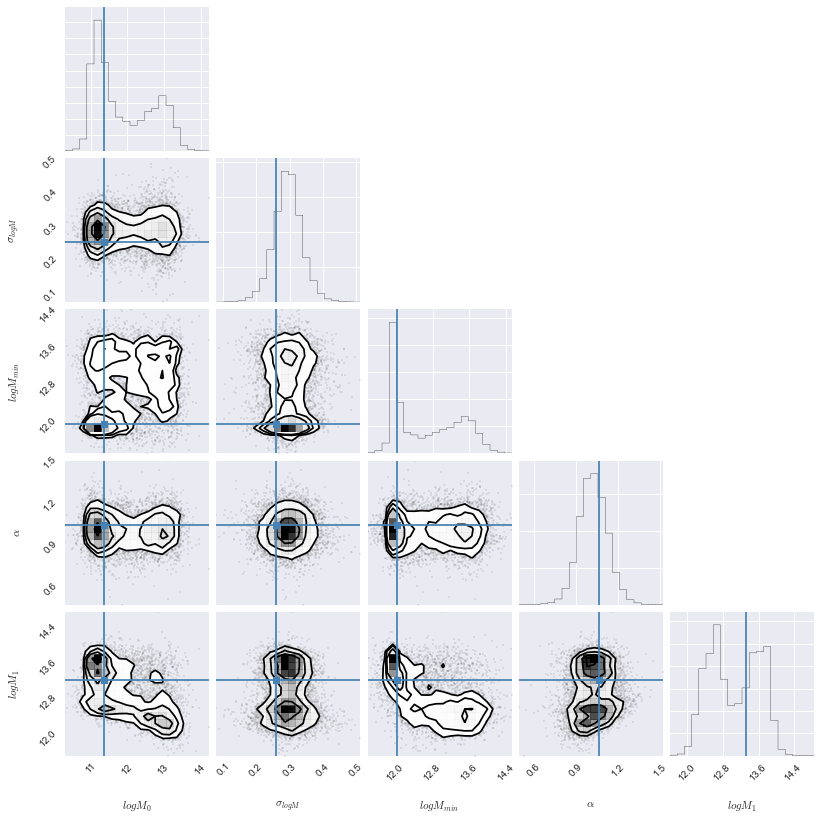

In [63]:
import seaborn as sns
import corner
samples = np.vstack([pool.thetas for pool in pools])
fig = corner.corner(samples, truths= true_hod, labels=[r"$log M_{0}$", r"$\sigma_{log M}$", r"$log M_{min}$",r"$\alpha$",r"$log M_1$"])